<a href="https://colab.research.google.com/github/philipoedi/Color-Spaces-and-Conv-Net/blob/master/convnet_color_spaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Color spaces and Convnet Performance**


1.   Setup Working space and get data
2.   Data preprocessing for different color spaces
3.   Create Convnet
4.   Train Convnet on different preprocessed images
  -   Save model, learning history, evaluation metrics
5. Evaluation plots

## **1. Setup Up Working space and get data**

In [ ]:
!pip install tensorflow==2.*

In [ ]:
# download training images, test images and ground truth

%%shell
wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

--2020-07-22 13:00:38--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘GTSRB_Final_Test_Images.zip’

GTSRB_Final_Test_Im 100%[===================>]  84.86M  18.6MB/s    in 4.6s    

2020-07-22 13:00:43 (18.6 MB/s) - ‘GTSRB_Final_Test_Images.zip’ saved [88978620/88978620]

--2020-07-22 13:00:43--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  23

In [ ]:
%%shell
unzip GTSRB_Final_Test_GT.zip
unzip GTSRB_Final_Test_Images.zip
unzip GTSRB_Final_Training_Images.zip
rm GTSRB_Final_Training_Images.zip 
rm GTSRB_Final_Test_Images.zip 
rm GTSRB_Final_Test_GT.zip

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB/Final_Training/Images/00035/00000_00020.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00021.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00022.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00023.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00024.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00025.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00026.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00027.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00028.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00029.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00000.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00001.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00002.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00003.ppm  
  inflating: GTSRB/Final_Training/Image

In [ ]:
cd GTSRB

/content/GTSRB


In [ ]:
%pycat Readme-Images.txt

In [ ]:
cd ..

/content


In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import Image

In [ ]:
# connect gdrive, so that we can later save models
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## **2. Data Preprocessing and different color spaces**

colorspaces: rgb, gray, yuv, yiq, hsv


In [ ]:
PATH_TRAIN_DATA = "/content/GTSRB/Final_Training/Images" 
PATH_TEST_DATA = "/content/GTSRB/Final_Test/Images"
PATH_TO_TEST_LABELS = "/content/GT-final_test.csv"
PATH_SAVE = "/content/gdrive/My Drive/bga2"
NUM_CLASSES = 43

In [ ]:
classes_list = sorted(os.listdir(PATH_TRAIN_DATA))
print(classes_list)

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


In [ ]:
#embedded colorspace conversion in ImageDataGenerator via preprocessing function

#RGB
data_gen_train_rgb = ImageDataGenerator(rescale=1./255,validation_split=0.2)
data_gen_test_rgb = ImageDataGenerator(rescale=1./255)
#gray
#data_gen_train_gray = ImageDataGenerator(rescale=1./255,validation_split=0.2,preprocessing_function = tf.image.rgb_to_grayscale)
#data_gen_test_gray = ImageDataGenerator(rescale=1./255,preprocessing_function = tf.image.rgb_to_grayscale)
data_gen_train_gray = ImageDataGenerator(rescale=1./255,validation_split=0.2)
data_gen_test_gray = ImageDataGenerator(rescale=1./255)

#hsv
data_gen_train_hsv = ImageDataGenerator(rescale=1./255,validation_split=0.2,preprocessing_function = tf.image.rgb_to_hsv)
data_gen_test_hsv = ImageDataGenerator(rescale=1./255,preprocessing_function = tf.image.rgb_to_hsv)
#yuv
data_gen_train_yuv = ImageDataGenerator(rescale=1./255,validation_split=0.2,preprocessing_function = tf.image.rgb_to_yuv)
data_gen_test_yuv = ImageDataGenerator(rescale=1./255,preprocessing_function = tf.image.rgb_to_yuv)
#yiq
data_gen_train_yiq = ImageDataGenerator(rescale=1./255,validation_split=0.2,preprocessing_function = tf.image.rgb_to_yiq)
data_gen_test_yiq = ImageDataGenerator(rescale=1./255,preprocessing_function = tf.image.rgb_to_yiq)


In [ ]:
#load ground truth

test_labels = pd.read_csv(PATH_TO_TEST_LABELS,sep=";")
print(test_labels.columns)
#adjust classids to 000xx to correspond with folder structure
test_labels["ClassId"] = test_labels["ClassId"].apply(lambda x: str(x).zfill(5))
test_labels = test_labels[["Filename","ClassId"]]
print(test_labels.head())

Index(['Filename', 'Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2',
       'ClassId'],
      dtype='object')
    Filename ClassId
0  00000.ppm   00016
1  00001.ppm   00001
2  00002.ppm   00038
3  00003.ppm   00033
4  00004.ppm   00011


In [ ]:
# create data generator for train and validation data

#RGB
train_data_rgb = data_gen_train_rgb.flow_from_directory(PATH_TRAIN_DATA,target_size = (64,64),classes = classes_list,seed=1,
                                                batch_size=64, subset='training')
valid_data_rgb = data_gen_train_rgb.flow_from_directory(PATH_TRAIN_DATA,target_size = (64,64),classes = classes_list,seed=1,
                                                batch_size=64, subset='validation')
#gray
train_data_gray = data_gen_train_gray.flow_from_directory(PATH_TRAIN_DATA,target_size = (64,64),classes = classes_list,seed=1,
                                                batch_size=64, subset='training',color_mode="grayscale")
valid_data_gray = data_gen_train_gray.flow_from_directory(PATH_TRAIN_DATA,target_size = (64,64),classes = classes_list,seed=1,
                                                batch_size=64, subset='validation',color_mode="grayscale")
#hsv
train_data_hsv = data_gen_train_hsv.flow_from_directory(PATH_TRAIN_DATA,target_size = (64,64),classes = classes_list,seed=1,
                                                batch_size=64, subset='training')
valid_data_hsv = data_gen_train_hsv.flow_from_directory(PATH_TRAIN_DATA,target_size = (64,64),classes = classes_list,seed=1,
                                                batch_size=64, subset='validation')
#yuv
train_data_yuv = data_gen_train_yuv.flow_from_directory(PATH_TRAIN_DATA,target_size = (64,64),classes = classes_list,seed=1,
                                                batch_size=64, subset='training')
valid_data_yuv = data_gen_train_yuv.flow_from_directory(PATH_TRAIN_DATA,target_size = (64,64),classes = classes_list,seed=1,
                                                batch_size=64, subset='validation')
#yiq
train_data_yiq = data_gen_train_yiq.flow_from_directory(PATH_TRAIN_DATA,target_size = (64,64),classes = classes_list,seed=1,
                                                batch_size=64, subset='training')
valid_data_yiq = data_gen_train_yiq.flow_from_directory(PATH_TRAIN_DATA,target_size = (64,64),classes = classes_list,seed=1,
                                                batch_size=64, subset='validation')




Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [ ]:
assert valid_data_gray.filenames == valid_data_rgb.filenames, print("not same valid and train data for different color spaces")

True

In [ ]:
# create data generator for test data
#rgb
test_data_rgb = data_gen_test_rgb.flow_from_dataframe(test_labels, directory=PATH_TEST_DATA, 
                                              x_col='Filename',y_col='ClassId',
                                              classes=classes_list, seed=1,
                                              target_size=(64, 64), shuffle=False,batch_size = 1)
#gray
test_data_gray = data_gen_test_gray.flow_from_dataframe(test_labels, directory=PATH_TEST_DATA, 
                                              x_col='Filename',y_col='ClassId',
                                              classes=classes_list, seed=1,
                                              target_size=(64, 64), shuffle=False,batch_size = 1,color_mode="grayscale")
#hsv
test_data_hsv = data_gen_test_hsv.flow_from_dataframe(test_labels, directory=PATH_TEST_DATA, 
                                              x_col='Filename',y_col='ClassId',
                                              classes=classes_list, seed=1,
                                              target_size=(64, 64), shuffle=False,batch_size = 1)
#yuv
test_data_yuv = data_gen_test_yuv.flow_from_dataframe(test_labels, directory=PATH_TEST_DATA, 
                                              x_col='Filename',y_col='ClassId',
                                              classes=classes_list, seed=1,
                                              target_size=(64, 64), shuffle=False,batch_size = 1)
#yiq
test_data_yiq = data_gen_test_yiq.flow_from_dataframe(test_labels, directory=PATH_TEST_DATA, 
                                              x_col='Filename',y_col='ClassId',
                                              classes=classes_list, seed=1,
                                              target_size=(64, 64), shuffle=False,batch_size = 1)

Found 12630 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.


In [ ]:
#check if all pictures are in test data generator
assert len(test_labels) == 12630, print("not all pics")  

In [ ]:
# set up dictionary with holding data

color_spaces = ["rgb","gray","hsv","yuv","yiq"]
color_spaces_dict = {"rgb":{"train_data": train_data_rgb,
                       "validation_data": valid_data_rgb,
                       "test_data": test_data_rgb,
                       "num_channels": 3},
                "gray":{"train_data": train_data_gray,
                       "validation_data": valid_data_gray,
                       "test_data": test_data_gray,
                       "num_channels": 1},
                "hsv":{"train_data": train_data_hsv,
                       "validation_data": valid_data_hsv,
                       "test_data": test_data_hsv,
                       "num_channels": 3},
                "yuv":{"train_data": train_data_yuv,
                       "validation_data": valid_data_yuv,
                       "test_data": test_data_yuv,
                       "num_channels": 3},
                "yiq":{"train_data": train_data_yiq,
                       "validation_data": valid_data_yiq,
                       "test_data": test_data_yiq,
                       "num_channels": 3}}

## **3. Create Convnet**

In [ ]:
def create_model(num_channels):
  model = models.Sequential()
  model.add(layers.Conv2D(32,(3,3),padding="same",input_shape = (64,64,num_channels),activation = "relu"))
  model.add(layers.Conv2D(32,(3,3),activation = "relu"))
  model.add(layers.MaxPooling2D(pool_size = (2,2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(64,(3,3),padding="same",activation = "relu"))
  model.add(layers.Conv2D(64,(3,3),activation = "relu"))
  model.add(layers.MaxPooling2D(pool_size = (2,2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Flatten())
  model.add(layers.Dense(512,activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(NUM_CLASSES,activation="softmax"))
  return model

## **4. Train Convnet**

In [ ]:
results = test_labels.copy()
results["ClassId"] = results["ClassId"].map(int)

#for color in color_spaces:
for color in color_spaces:
  data = color_spaces_dict[color]
  model = create_model(data["num_channels"])
  model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
  
  # save history to log file
  history_log_path = os.path.join(PATH_SAVE,"{}_history.log".format(color))
  csv_logger = tf.keras.callbacks.CSVLogger(history_log_path)
  hist = model.fit(data["train_data"], epochs=20, validation_data=data["validation_data"],callbacks = [csv_logger])
  
  #save model
  model_name = "{}.h5".format(color)
  save_model_path = os.path.join(PATH_SAVE,model_name)
  model.save(save_model_path)a
#  y_pred = np.argmax(model.predict(data["test_data"]),axis=-1)
#  classes_dict = data["test_data"].class_indices
#  tf_out_2_class_id = {class_dict[class_id]:class_id for class_id  in classes_list}
#  predictions = pd.DataFrame({"Filename":data["test_data"].filenames,"{}_pred".format(color):list(map(lambda x: tf_out_2_class_id[x],y_pred))})
#  predictions["{}_pred".format(color)] = predictions["{}_pred".format(color)].map(int)
#  results = pd.merge(results, predictions,how="inner",on="Filename")

# save dataframe with predicted labels
#save_results_path = os.path.join(PATH_SAVE,"results.csv")


#results.to_csv(save_results_path)

Epoch 1/20
491/491 [==============================] - 81s 165ms/step - loss: 1.0929 - accuracy: 0.6777 - val_loss: 0.4196 - val_accuracy: 0.8779
Epoch 2/20
491/491 [==============================] - 80s 162ms/step - loss: 0.1542 - accuracy: 0.9531 - val_loss: 0.3472 - val_accuracy: 0.9103
Epoch 3/20
491/491 [==============================] - 79s 160ms/step - loss: 0.0877 - accuracy: 0.9729 - val_loss: 0.3279 - val_accuracy: 0.9152
Epoch 4/20
491/491 [==============================] - 79s 161ms/step - loss: 0.0641 - accuracy: 0.9796 - val_loss: 0.2198 - val_accuracy: 0.9471
Epoch 5/20
491/491 [==============================] - 79s 160ms/step - loss: 0.0474 - accuracy: 0.9852 - val_loss: 0.2835 - val_accuracy: 0.9314
Epoch 6/20
491/491 [==============================] - 79s 160ms/step - loss: 0.0414 - accuracy: 0.9866 - val_loss: 0.2469 - val_accuracy: 0.9445
Epoch 7/20
491/491 [==============================] - 78s 158ms/step - loss: 0.0355 - accuracy: 0.9887 - val_loss: 0.2256 - val_ac

In [ ]:
#get predictions

results = test_labels.copy()
results["ClassId"] = results["ClassId"].map(int)
for color in color_spaces:
  data = color_spaces_dict[color]
  model_name = "{}.h5".format(color)
  save_model_path = os.path.join(PATH_SAVE,model_name)  
  model = models.load_model(save_model_path)
  y_pred = np.argmax(model.predict(data["test_data"]),axis=-1)
  classes_dict = data["test_data"].class_indices
  tf_out_2_class_id = {class_dict[class_id]:class_id for class_id  in classes_list}
  predictions = pd.DataFrame({"Filename":data["test_data"].filenames,"{}_pred".format(color):list(map(lambda x: tf_out_2_class_id[x],y_pred))})
  predictions["{}_pred".format(color)] = predictions["{}_pred".format(color)].map(int)
  results = pd.merge(results, predictions,how="inner",on="Filename")
# save dataframe with predicted labels
save_results_path = os.path.join(PATH_SAVE,"results.csv")
results.to_csv(save_results_path)

NameError: ignored

In [ ]:
# calculate precision, recall, f1-score and save to file
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

avg_metrics = pd.DataFrame()
all_metrics = pd.DataFrame()
avg_cols = ["accuracy","macro avg","weighted avg"]
for color in color_spaces:
  metrics = classification_report(results["ClassId"],results["{}_pred".format(color)],output_dict= True)
  metrics = pd.DataFrame(metrics).transpose()
  metrics["color"] = color
  avg_metrics = pd.concat([avg_metrics,metrics[np.isin(metrics.index.values,avg_cols)]])
  all_metrics = pd.concat([all_metrics,metrics[~np.isin(metrics.index.values,avg_cols)].reset_index()])
all_metrics.columns = ["ClusterId","precision","recall","f1-score","support","color"]

avg_metrics.to_csv(os.path.join(PATH_SAVE,"avg_metrics.csv"))
all_metrics.to_csv(os.path.join(PATH_SAVE,"all_metrics.csv"))

## **5. Evaluation Plots**

In [ ]:
# validation and training error and accuracy dataframe
history_df = pd.DataFrame()

for color in color_spaces:
  history_path = os.path.join(PATH_SAVE,"{}_history.log".format(color))
  history_data = pd.read_csv(history_path)
  history_data["color"] = color
  history_df = pd.concat([history_df,history_data])
history_df.head()


,epoch,accuracy,loss,val_accuracy,val_loss,color
0,0,0.686018,1.085965,0.908175,0.319229,rgb
1,1,0.956102,0.146476,0.940824,0.226914,rgb
2,2,0.974177,0.083265,0.944267,0.233885,rgb
3,3,0.983901,0.055334,0.951154,0.210130,rgb
4,4,0.986642,0.044628,0.960082,0.152455,rgb


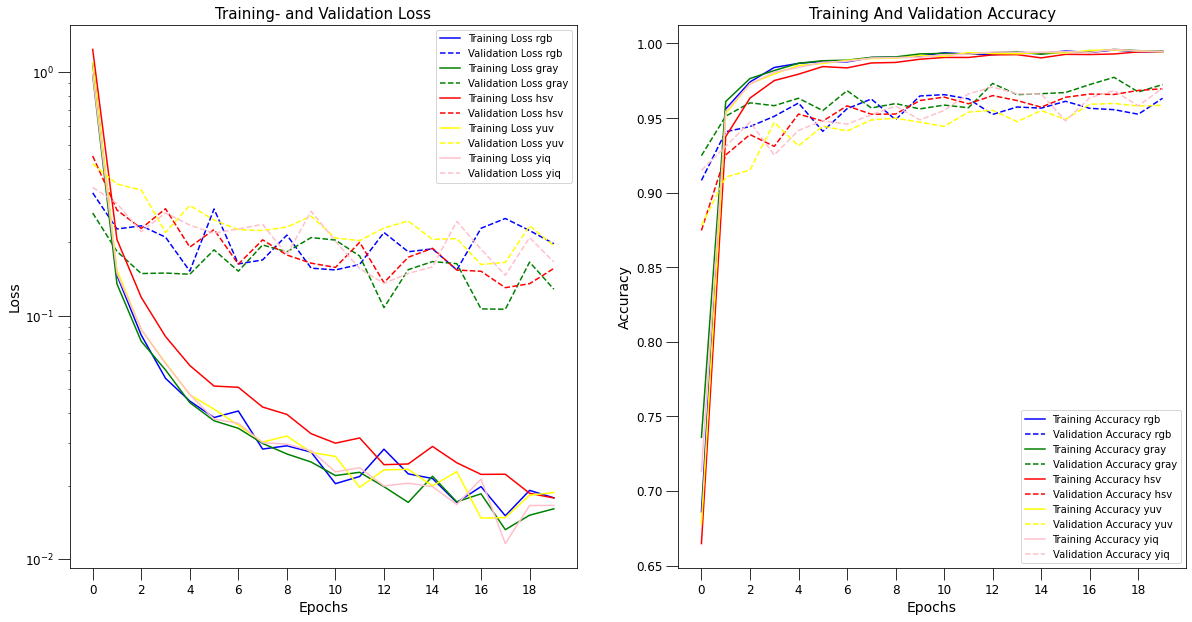

In [ ]:
# plot validation and training loss and accuracy
title_size = 15
legend_size = 10
label_size = 14
tick_size = 12
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1,2,2)  
accuracy_legend = list()
loss_legend = list()
color_dict = {"rgb":"blue","hsv":"red","gray":"green","yuv":"yellow","yiq":"pink"}


for color in color_spaces:

  plot_data = history_df[history_df["color"] == color]
  ax1.plot(plot_data["loss"],color=color_dict[color])
  loss_legend.append("Training Loss {}".format(color))
  ax1.plot(plot_data["val_loss"],"--",color=color_dict[color])
  loss_legend.append("Validation Loss {}".format(color))
  ax2.plot(plot_data["accuracy"],color=color_dict[color])
  accuracy_legend.append("Training Accuracy {}".format(color))
  ax2.plot(plot_data["val_accuracy"],"--",color=color_dict[color])
  accuracy_legend.append("Validation Accuracy {}".format(color))
ax1.set_yscale('log')
ax1.set_xticks(np.arange(0,20,2))
ax1.set_title("Training- and Validation Loss",size = title_size)
ax1.set_xlabel("Epochs",size = label_size)
ax1.set_ylabel("Loss",size = label_size)
ax1.tick_params(length = tick_size,labelsize = tick_size)
ax1.legend(loss_legend)
ax2.set_xticks(np.arange(0,20,2))
ax2.set_title("Training And Validation Accuracy",size = title_size)
ax2.set_xlabel("Epochs",size = label_size)
ax2.set_ylabel("Accuracy",size = label_size)
ax2.tick_params(length = tick_size,labelsize = tick_size)
ax2.legend(accuracy_legend)
plt.show()

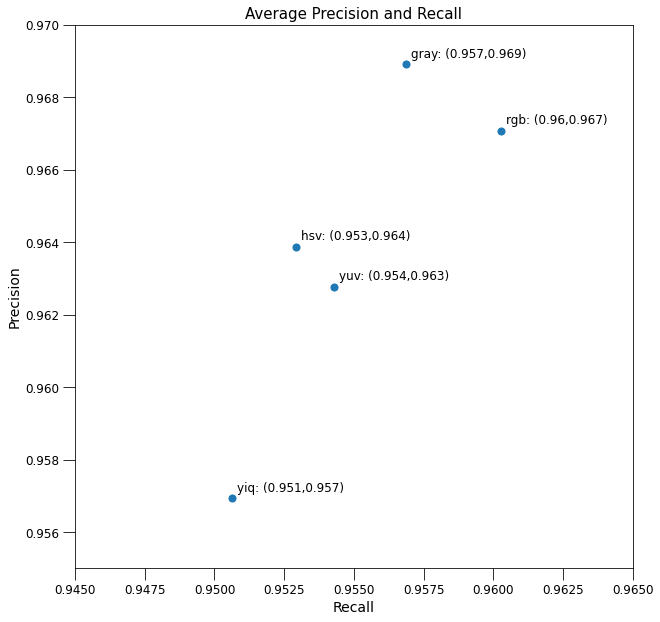

In [ ]:
# average precision and recall
avg_data = pd.read_csv(os.path.join(PATH_SAVE,"avg_metrics.csv"))
avg_data.rename(columns={'Unnamed: 0':"metrics"},inplace=True)
avgs = avg_data[avg_data["metrics"] == "macro avg"]


plt.figure(figsize=(10,10))
plt.scatter(avgs["recall"],avgs["precision"],s=50,marker="o")
plt.title("Average Precision and Recall",size=title_size)
plt.xlabel("Recall",size=label_size)
plt.ylabel("Precision",size=label_size)
for color in color_spaces:
  position = avgs[avgs["color"] == color][["recall","precision"]].values * 1.0002
  position = tuple(position[0])

  plt.annotate("{}: ({},{})".format(color,np.round(position[0],3),np.round(position[1],3)),position,size=12)
plt.xlim([0.945,0.965])
plt.ylim([0.955,0.97])
plt.tick_params(length=tick_size,labelsize=tick_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


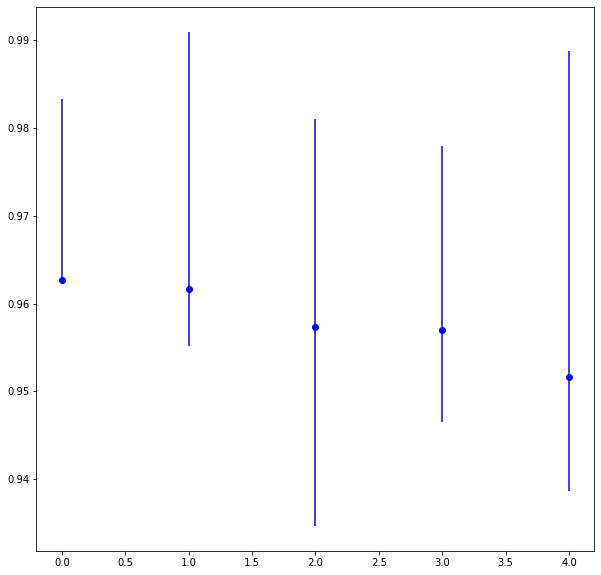

In [ ]:
# average precision and recall
def q1(x):
    return x.quantile(0.25)
def q2(x):
    return x.quantile(0.75)
all_data = pd.read_csv(os.path.join(PATH_SAVE,"all_metrics.csv"))
f1_scores = all_data.groupby("color").agg({"f1-score":["mean",q1,q2]})
f1_scores.columns = ["mean","q25","q75"]
f1_scores.sort_values("mean",ascending=False,inplace=True)
plt.figure(figsize=(10,10))
f1_scores.reset_index(inplace=True)
#plt.bar(x = f1_scores.index,height=f1_scores["mean"])
for i,color in enumerate(f1_scores["color"].values):
  plot_data = f1_scores[f1_scores["color"] == color]
  plot_data["q25"] = plot_data["mean"]- plot_data["q25"] 
  plot_data["q75"] = plot_data["q75"] - plot_data["mean"]
  plt.errorbar(x=i,y=plot_data["mean"],yerr=plot_data[["q25","q75"]].values.reshape((2,1)),c="b")
  plt.scatter(x=i,y=plot_data["mean"],c="b")
#plt.ylim([0.95,0.97])

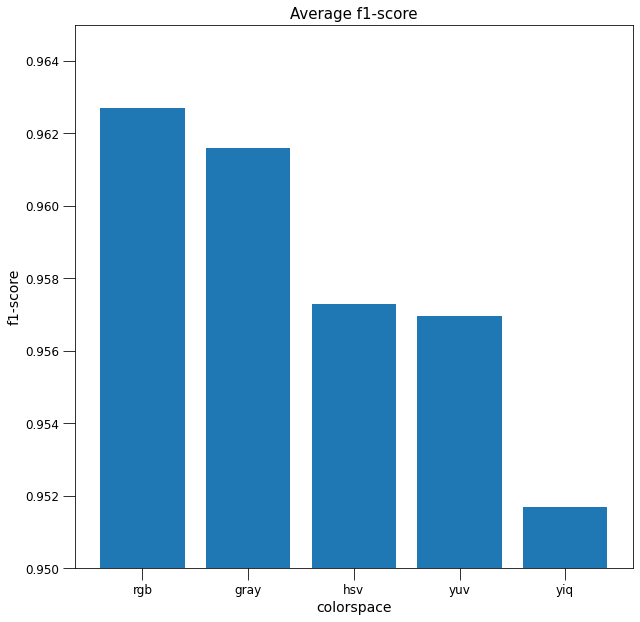

In [ ]:
# f1 - scores
plt.figure(figsize=(10,10))
plt.bar(x = avgs["color"],height= avgs["f1-score"])
plt.ylim([0.95,0.965])
plt.title("Average f1-score",size=title_size)
plt.ylabel("f1-score",size=label_size)
plt.xlabel("colorspace",size=label_size)
plt.tick_params(length=tick_size,labelsize=tick_size)
plt.show()


In [ ]:
import time
results = list()
for color in color_spaces:
  model_path = os.path.join(PATH_SAVE,"{}.h5".format(color))
  model = models.load_model(model_path)
  data = color_spaces_dict[color]
  test_data = data["test_data"]
  print("{}:".format(color))
  start = time.time()
  out = model.predict(test_data)
  total_time = time.time() - start
  results.append(total_time)
  print(total_time/len(test_data.filenames))
  print(total_time)
  print("------------------------")

rgb:
0.0013870237181324479
17.518109560012817
------------------------
gray:
0.0013877881300043513
17.527764081954956
------------------------
hsv:
0.002015514630508725
25.455949783325195
------------------------
yuv:
0.002824225939179071
35.669973611831665
------------------------
yiq:
0.0028535878007032527
36.04081392288208
------------------------


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 229488344537762848, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1606284328105195037
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16332593085056092984
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150726272
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4677560637800029491
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]